## DeepED Informer

In [1]:
!jupyter nbconvert --to script run_informer_deeped.ipynb

[NbConvertApp] Converting notebook run_informer_deeped.ipynb to script
[NbConvertApp] Writing 14555 bytes to run_informer_deeped.py


In [2]:
import torch
import os
import time 
import gc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

from utils.tools import dotdict
from exp.exp_informer import Exp_Informer, Exp_Informer_DeepED

In [3]:
args = dotdict()

args.model = 'informer_noT' # model of experiment, options: [informer, informerstack, informerlight(TBD)]
args.model = 'transformer_noT'

args.data = 'deeped' # data
args.root_path = os.path.join('Dataset', 'DeepED_dataset') # root path of data file
args.data_path = 'res_train4_test8_v02.npz' # data file
args.stat_path = 'data_stats.npz' # stat file
args.asi = 1
args.aei = 3

args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 12 # [idx : idx+seq_len]: input sequence length of Informer encoder
args.label_len = 1 # [idx+seq_len-label_len : idx+seq_len]: start token length of Informer decoder; overlap with seq_len counting from the end of seq_len
args.pred_len = 1 # [idx+seq_len : idx+seq_len+pred_len]: prediction sequence length; no overlap iwth seq_len
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 136 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 1
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0'


In [4]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
    
args.detail_freq = args.freq
args.freq = args.freq[-1:]
print(args.detrail_freq, args.freq)

None h


In [5]:
Exp = Exp_Informer_DeepED

In [6]:
ii = 0 # experiment index
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_asi{}_aei{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
            args.seq_len, args.label_len, args.pred_len, args.asi, args.aei,
            args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

# set experiments
exp = Exp(args)

Use GPU: cuda:0


In [7]:
# # debug
# train_data, train_loader = exp._get_data(flag = 'train')
# val_data, val_loader = exp._get_data(flag = 'val')
# test_data, test_loader = exp._get_data(flag = 'test')

# a, b = train_data[0]
# print(a.shape, b.shape)

# for i, (batch_x,batch_y) in enumerate(train_loader):
#   batch_x = batch_x.float().to(exp.device)
#   batch_y = batch_y.float()
  
#   dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()

#   dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
  
#   pred = exp.model(batch_x, dec_inp)
#   break

In [7]:
# train
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
exp.train(setting)

# test             
print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
exp.test(setting)

>>>>>>>start training : transformer_noT_deeped_ftM_sl12_ll1_pl1_asi1_aei3_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train data size x=(33280, 12, 136), y=(33280, 2, 7)
train 33280
val data size x=(3680, 12, 136), y=(3680, 2, 7)
val 3680
test data size x=(7840, 12, 136), y=(7840, 2, 7)
test 7840
	iters: 100, epoch: 1 | loss: 0.0796064
	speed: 0.0610s/iter; left time: 57.4049s
	iters: 200, epoch: 1 | loss: 0.0768073
	speed: 0.0127s/iter; left time: 10.6664s
	iters: 300, epoch: 1 | loss: 0.0867499
	speed: 0.0132s/iter; left time: 9.8106s
	iters: 400, epoch: 1 | loss: 0.0622987
	speed: 0.0130s/iter; left time: 8.3283s
	iters: 500, epoch: 1 | loss: 0.0870776
	speed: 0.0128s/iter; left time: 6.9317s
	iters: 600, epoch: 1 | loss: 0.0403367
	speed: 0.0128s/iter; left time: 5.6530s
	iters: 700, epoch: 1 | loss: 0.0435906
	speed: 0.0135s/iter; left time: 4.6042s
	iters: 800, epoch: 1 | loss: 0.0515782
	speed: 0.0131s/iter; left time: 3.1689s
	iters

In [9]:
# for ii in range(args.itr):
#     # setting record of experiments
#     setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
#                 args.seq_len, args.label_len, args.pred_len,
#                 args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

#     # set experiments
#     exp = Exp(args)

#     # train
#     print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
#     exp.train(setting)

#     # test
#     print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
#     exp.test(setting)

#     torch.cuda.empty_cache()

### Prediction

In [8]:
#-- resutl output path
DIR_INT = os.path.join('Dataset', 'DeepED_dataset')
# DIR_OUT = 'results'

# output bands
TREE_BAND = ['height', 'agb', 'soil', 'lai', 'gpp', 'npp', 'rh']


# parameters
N_T = 12 
N_YEAR = 40
N_AGE = 15
N_OUT = len(TREE_BAND)

N_CONS = 136 # number of atmos features
N_FEA = N_CONS + N_OUT + 15 # add age info

eval_filename = 'res_train4_test8_v02.npz'
agetri_filename = 'age_triplet.npz'
stat_filename = 'data_stats.npz'

isDup = True

# read stat data
data_stat = np.load(os.path.join(DIR_INT, stat_filename))
X_MEAN = data_stat['x_mean']
Y_MEAN = data_stat['y_mean']
X_STD = data_stat['x_std']
Y_STD = data_stat['y_std']

# read age
age_triplet = np.load(os.path.join(DIR_INT, agetri_filename))
TRI_AGE = age_triplet['age']
TRI_MEAN = age_triplet['age_mean']
TRI_SLOPE = age_triplet['age_slope']

age_start_idx = 1
age_end_idx = 2

# select age
TRI_AGE = TRI_AGE[age_start_idx:age_end_idx]
TRI_MEAN = TRI_MEAN[age_start_idx:age_end_idx]
TRI_SLOPE = TRI_SLOPE[age_start_idx:age_end_idx]
N_AGE = TRI_AGE.size
print(f'Working on age: {TRI_AGE}')

age_tri = [TRI_AGE, TRI_MEAN, TRI_SLOPE]
data_stat = [X_MEAN, X_STD, Y_MEAN, Y_STD]


def normData(inp, mean, std): 
  # assert inp.shape[-1] == mean.size
  # assert std.size == mean.size
  
  return (inp-mean)/(std+1e-10)

def invNormData(inp, mean, std): 
  # assert inp.shape[-1] == mean.size
  # assert std.size == mean.size
  
  return inp*(std+1e-10)+mean

def dupMonth(y, dup_idx=11):
  # assert dup_idx < N_T
  
  return np.repeat(y[...,dup_idx:dup_idx+1,:], N_T, axis=-2)

def addAgeTriplet_perAge(x, np_age, np_mean, np_slope):
  ''' 
  For x with all ages, add age triplet to the last dimension of x
    x: [N_Sample, N_YEAR, N_T, N_BAND]
    np_age: [1]
    np_mean/np_slope: [N_BAND]
  '''
  # form data structure
  res_mean = np.repeat(np_mean[np.newaxis], x.shape[2], axis=0)
  res_mean = np.repeat(res_mean[np.newaxis], x.shape[1], axis=0)
  res_mean = np.repeat(res_mean[np.newaxis], x.shape[0], axis=0)
  res_slope = np.repeat(np_slope[np.newaxis], x.shape[2], axis=0)
  res_slope = np.repeat(res_slope[np.newaxis], x.shape[1], axis=0)
  res_slope = np.repeat(res_slope[np.newaxis], x.shape[0], axis=0)
  
  res_age = np.arange(N_YEAR)[np.newaxis] + np_age
  res_age = np.transpose(res_age, (1,0))
  res_age = np.repeat(res_age[:,np.newaxis], x.shape[-2], axis=1)
  res_age = np.repeat(res_age[np.newaxis], x.shape[0], axis=0)
  
  # scale age
  res_age = res_age / 500.
  
  # concat
  res = np.concatenate([x, res_age.astype(np.float32)], axis=-1)
  res = np.concatenate([res, res_mean.astype(np.float32)], axis=-1)
  res = np.concatenate([res, res_slope.astype(np.float32)], axis=-1)
  
  return res
  
  
def addInitY2X(x, y): 
  out = np.repeat(x[np.newaxis], y.shape[0], axis=0)
  return np.concatenate([out, y[:,:,:-1]], axis=-1)

[tri_age, tri_mean, tri_slope] = age_tri
[x_mean, x_std, y_mean, y_std] = data_stat

print(f'  Target age: {tri_age}')  
  

def plotAge(np_rmse, TRI_AGE, isOutput=True, path_out='', y_lim=[0,3.5]):
  # plot age
  num_age = np_rmse.shape[0]
  ls_cor = ['r','g','b','c','y','m','k']
  
  if num_age == 1: 
    fig_r = 1
    fig_c = 2
    figsize = (4,3)
    
    fig = plt.figure(figsize=figsize)
    cur_rmse = np_rmse[0]
    for k in range(N_OUT):
      plt.plot(cur_rmse[:,k], ls_cor[k], label=TREE_BAND[k])
    
    plt.ylim(y_lim)
    plt.title('Age'+str(TRI_AGE[0])) 
    plt.ylabel('RMSE')
    # plt.set_xticks(list(range(0,32,30)))
    # plt.set_xticklabels(list(range(1986,2017,30)))

    plt.legend(loc=0, prop={'size': 7})

  else: 
    fig_r = 3
    fig_c = 5
    figsize = (10,7)
    
    plt.figure()
    fig, axes = plt.subplots(fig_r, fig_c, figsize=figsize)
    for i in range(fig_r):
      for j in range(fig_c):
        if i*fig_c+j < num_age: 
          cur_rmse = np_rmse[i*fig_c+j]
          for k in range(N_OUT):
            axes[i,j].plot(cur_rmse[:,k], ls_cor[k])

          # axes[i,j].set_xticks(list(range(0,32,30)))
          # axes[i,j].set_xticklabels(list(range(1986,2017,30)))
          axes[i,j].set_ylim(y_lim)
          axes[i,j].set_title('Age'+str(TRI_AGE[i*fig_c+j]))
          
      axes[i,0].set_ylabel('RMSE')

    # add legend
    for k in range(N_OUT):
      axes[i,j].plot([0], [0], ls_cor[k], label=TREE_BAND[k])
    axes[i,j].legend(loc=10, prop={'size': 7})   
    
  # save 
  fig.tight_layout()
  if isOutput:
    plt.savefig(path_out+'_fig', bbox_inches='tight')
  print('  Plot done!\n')      


def convertRMSE2Table(ls_rmse_all, TRI_AGE): 
  rmse = np.transpose(ls_rmse_all, [0,2,1])
  pd_rmse = pd.DataFrame(rmse.reshape((-1, rmse.shape[2])))
  tmp = pd.DataFrame(np.repeat(TRI_AGE, N_OUT), columns=['age'])
  pd_rmse = pd.concat([tmp, pd_rmse], axis=1)
  return pd_rmse


# predict using prediction
def eval(emulator, path_test, path_out, age_tri, data_stat, age_used_idx, isPred2Input=True, isTrain=False, isOutput=True, isDup=True, y_lim=[0,3.5]):
  print('--- Start evaluation ---')
  
  [tri_age, tri_mean, tri_slope] = age_tri
  [x_mean, x_std, y_mean, y_std] = data_stat
  [age_start_idx, age_end_idx] = age_used_idx
  
  print(f'  Target age: {tri_age}')  
  
  #--- Loading data ---  
  data_train = np.load(path_test)
  if not isTrain:
    x_name = 'x_test'
    y_name = 'y_test' 
  else: 
    x_name = 'x_train'
    y_name = 'y_train'

  x_test = normData(data_train[x_name], x_mean, x_std)
  y_test = normData(data_train[y_name], y_mean, y_std)
  
  y_test = y_test[age_start_idx:age_end_idx]

  del data_train
  gc.collect()
  
  print(f'X shape: {x_test.shape}, Y shape: {y_test.shape}')
  
  emulator.model.eval()


  #--- Preprocessing ---
  # duplicate annual prediction
  if isDup: 
    y_test = dupMonth(y_test, dup_idx=11)

  age_mean = normData(tri_mean, y_mean, y_std)
  age_slope = normData(tri_slope, y_mean, y_std)

  t_start = time.time()
  ls_rmse_all = []
  ls_pred_all = []
  for cur_age in tqdm(range(tri_age.size)):

    # append init
    cur_x = addInitY2X(x_test, y_test[cur_age:cur_age+1])
    cur_x = cur_x[0]
    cur_y = y_test[cur_age,:,1:,-1]
    # logging.info(cur_x.shape, cur_y.shape) # (852, 40, 12, 143) (852, 40, 7)

    # add age
    cur_x = addAgeTriplet_perAge(cur_x, tri_age[cur_age:(cur_age+1)], 
                            age_mean[cur_age], age_slope[cur_age])

    # predict
    ls_pred = []
    ls_rmse = []
    x_shape = cur_x.shape
    for i in range(x_shape[1]):
      tmp_x = cur_x[:,i].copy() # (B, 12, 158)
      tmp_y = cur_y[:,i].copy() # (B, 7)
      if i>0:
        if isPred2Input:
          # replace init tree height with prediction
          tmp_x[:,:,N_CONS:(N_CONS+N_OUT)] = np.repeat(ls_pred[-1][:,np.newaxis,:], N_T, axis=1)
      
      # use target only
      tmp_y = np.expand_dims(tmp_y, axis=1) # (B, 1, 7)
      tmp_y = np.concatenate([tmp_x[:, 0:1, 136:143], tmp_y], axis=1) # (B, 2, 7)
      tmp_x = tmp_x[:, :, :136] # (B, 12, 136)
      
      # # use age triplets
      # tmp_y = np.expand_dims(tmp_y, axis=1) # (B, 1, 7)
      # tmp_y1 = tmp_x[:, 0:1, 136:] # (batch*40, 1, 22)
      # tmp_y2 = np.concatenate([tmp_y, np.zeros((tmp_y.shape[0], 1, 15))], 2) # (batch*40, 1, 22)
      # tmp_y = np.concatenate([tmp_y1, tmp_y2], 1) # (batch*40, 2, 22)
      # tmp_x = tmp_x[:, :, :136] # (B, 12, 136)
          
      cur_pred, _ = emulator._process_one_batch(0, torch.tensor(tmp_x), torch.tensor(tmp_y))
      cur_pred = cur_pred.detach().cpu().numpy().squeeze()
  
      # post-processing
      zero_idx = invNormData(tmp_y[:,0,0],y_mean[0],y_std[0]) < 1
      # zero_idx = invNormData(cur_y[:,i,0],y_mean[0],y_std[0]) < 1
      cur_pred[zero_idx,0] = normData(np.array([0.],dtype=np.float32),y_mean[0],y_std[0])

      # save
      ls_pred.append(cur_pred)
      ls_rmse.append(mean_squared_error(invNormData(cur_y[:,i],y_mean,y_std), 
                                        invNormData(ls_pred[-1],y_mean,y_std), 
                                        multioutput='raw_values', squared=False))

    ls_rmse_all.append(np.array(ls_rmse))
    ls_pred_all.append(np.array(ls_pred))
    
    del cur_x, cur_y, tmp_x, cur_pred
    gc.collect()
    
  ls_rmse_all = np.array(ls_rmse_all)
  ls_pred_all = np.array(ls_pred_all)
  if isOutput:
    np.save(path_out+'_pred.npy', ls_pred_all)

    pd_acc = convertRMSE2Table(ls_rmse_all, tri_age)
    pd_acc.to_csv(path_out+'_acc_details.csv', index=False)
  print('  Spent {:.1f} min for evaluation.\n'.format((time.time()-t_start)/60))
  
  # plot age
  plotAge(ls_rmse_all, tri_age, isOutput, path_out, y_lim)
  
  return [y_test, ls_pred_all, ls_rmse_all]


Working on age: [10]
  Target age: [10]


--- Start evaluation ---
  Target age: [10]
X shape: (98, 40, 12, 136), Y shape: (1, 98, 41, 12, 7)


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


  Spent 0.0 min for evaluation.

  Plot done!



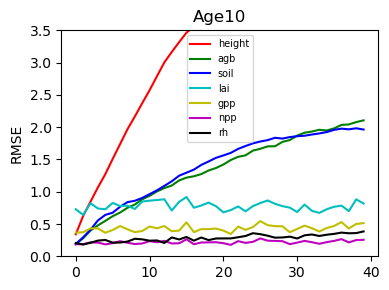

In [10]:
dir_out = './results/' + setting +'/'

_ = eval(exp, 
  os.path.join(args.root_path, 'res_train4_test8_v02.npz'), 
  dir_out+'test_pred', 
  age_tri, data_stat, [age_start_idx,age_end_idx], 
  isPred2Input=True, isTrain=False, isOutput=True, isDup=True, y_lim=[0,3.5])

_ = eval(exp, 
  os.path.join(args.root_path, 'res_train4_test8_v02.npz'), 
  dir_out+'test_true', 
  age_tri, data_stat, [age_start_idx,age_end_idx], 
  isPred2Input=False, isTrain=False, isOutput=True, isDup=True, y_lim=[0,3.5])